In [116]:
import os
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def set_seed(seed: int = 111):
    random.seed(seed)
    np.random.seed(seed)


set_seed(111)

In [117]:
from datasets import load_dataset
df = load_dataset("mnemoraorg/wine-quality-6k4")["train"].to_pandas()

In [118]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>]], dtype=object)

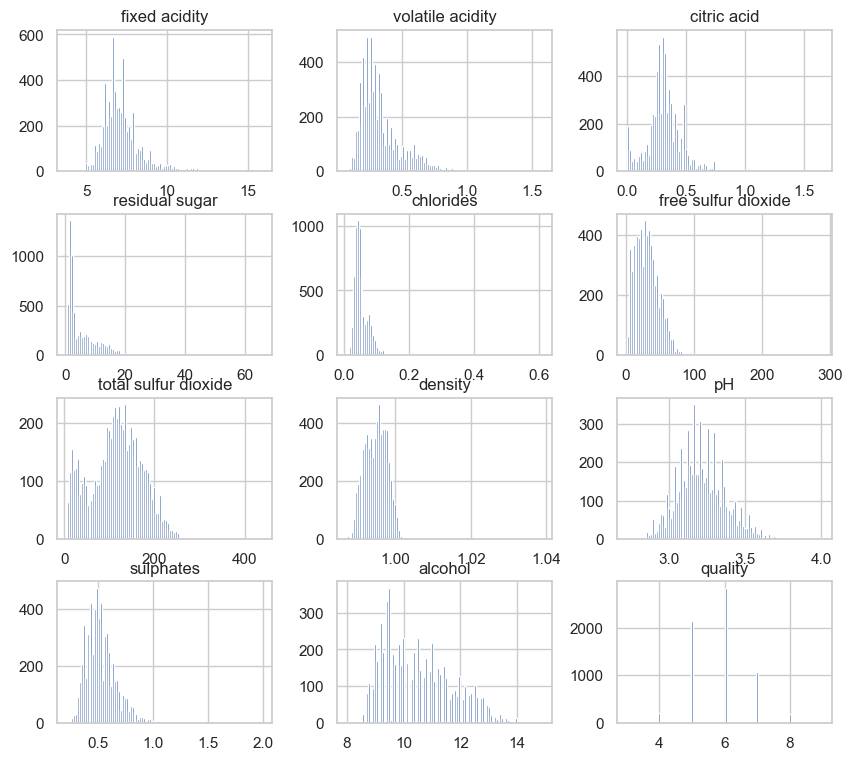

In [119]:
df.hist(figsize=(10, 9), bins=100)

<Axes: >

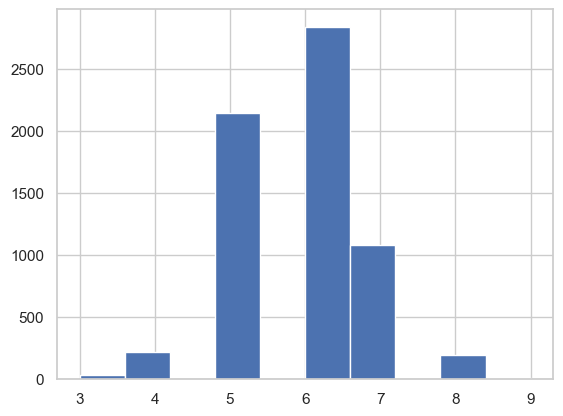

In [120]:
df['quality'].hist()

Обратив внимание, что есть сильный перекос значений в области от 5 до 7. Что в целом может говорить о том, что модель может научиться предсказывать число между одним из этих чисел и уже сильно понизит лосс

In [121]:
from sklearn.model_selection import train_test_split

n_before = len(df)
n_duplicates = df.duplicated().sum()

print(f"Размер до удаления дубликатов: {df.shape}")
print(f"Число полностью дублирующихся строк: {n_duplicates}")

df = df.drop_duplicates().reset_index(drop=True)

# df = df.groupby('quality').head(100).reset_index(drop=True) # Пробовал выравнять количество классов 100 / 250 / 500, не помогло сделать сильно лучше, выборка маловата

n_after = len(df)
print(f"Размер после удаления дубликатов: {df.shape}")
print(f"Фактически удалено строк: {n_before - n_after}")

target_col = "quality"

drop_cols = [target_col]
feature_cols = [c for c in df.columns if c not in drop_cols]

def split_data(features):
    X = df[features]
    y = df[target_col].apply(lambda x: x - 1)

    print("\nЧисло признаков:", X.shape[1])
    print("Список признаков:", features)

    # 20% в тест
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=111
    )

    # Из оставшихся 80% -> 60% train, 20% val
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=111
    )  # 0.25 * 0.8 = 0.2

    print("\nTrain:", X_train.shape, y_train.shape)
    print("Val:  ", X_val.shape,   y_val.shape)
    print("Test: ", X_test.shape,  y_test.shape)

    return X_test, y_test, X_train, y_train, X_val, y_val

Размер до удаления дубликатов: (6497, 12)
Число полностью дублирующихся строк: 1179
Размер после удаления дубликатов: (5318, 12)
Фактически удалено строк: 1179


<Axes: >

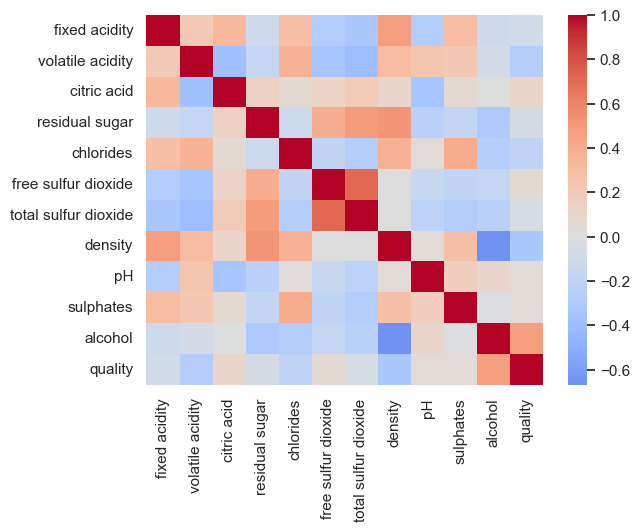

In [122]:
import seaborn as sns

sns.heatmap(df[feature_cols + [target_col]].corr(), annot=False, cmap='coolwarm', center=0)

In [123]:
def show_corr(correlation, colors='blue'):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(correlation.keys(), correlation.values(), color=colors)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')  
        label.set_va('top')    
        label.set_fontsize(8)
        

    plt.xlabel('Признаки')
    plt.ylabel('Корреляция')
    plt.title(f'Корреляция признаков с {target_col}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

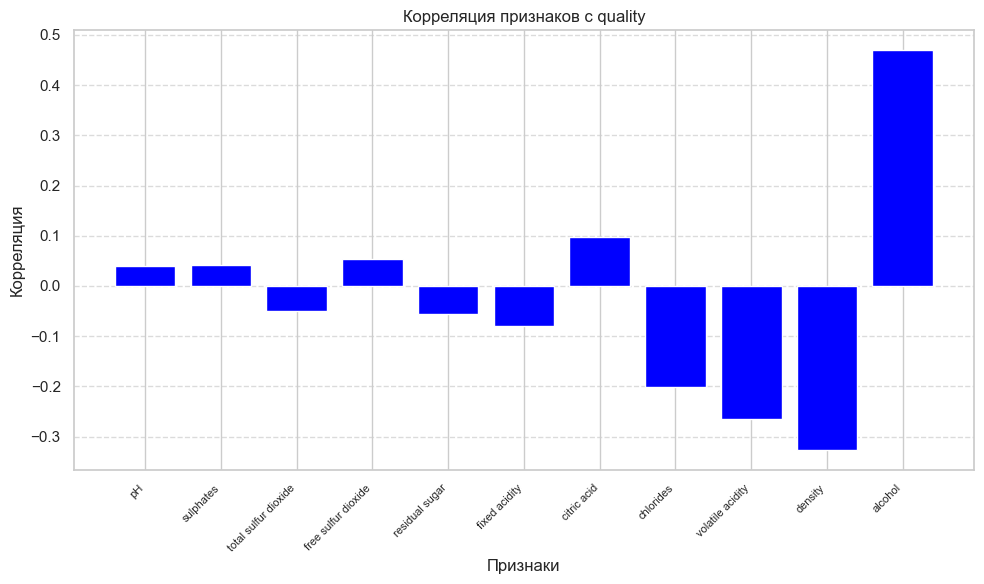

In [124]:
correlation = df[feature_cols].corrwith(df[[target_col]].iloc[:, 0]).sort_values(key=abs).dropna().to_dict()

show_corr(correlation)

In [125]:
X_test, y_test, X_train, y_train, X_val, y_val = split_data(feature_cols)


Число признаков: 11
Список признаков: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Train: (3190, 11) (3190,)
Val:   (1064, 11) (1064,)
Test:  (1064, 11) (1064,)


In [126]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


results = {}

def log_results(model_name: str, split: str, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if model_name not in results:
        results[model_name] = {}

    results[model_name][split] = {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
    }

def print_metrics(split_name: str, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"=== {split_name} ===")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R2  : {r2:.4f}")
    print()

In [127]:
baseline_name = "Baseline: mean"

# средняя аренда только по train
y_train_mean = y_train.mean()
print(f"Среднее качество на train: {y_train_mean:.2f}")

# предсказания: одно и то же число для всех объектов
y_train_pred = np.full_like(y_train, fill_value=y_train_mean, dtype=float)
y_val_pred   = np.full_like(y_val,   fill_value=y_train_mean, dtype=float)
y_test_pred  = np.full_like(y_test,  fill_value=y_train_mean, dtype=float)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Среднее качество на train: 4.79
Модель: Baseline: mean
=== Train ===
MSE : 0.77
RMSE: 0.88
MAE : 0.69
R2  : 0.0000

=== Val ===
MSE : 0.76
RMSE: 0.87
MAE : 0.69
R2  : -0.0000

=== Test ===
MSE : 0.81
RMSE: 0.90
MAE : 0.72
R2  : -0.0027



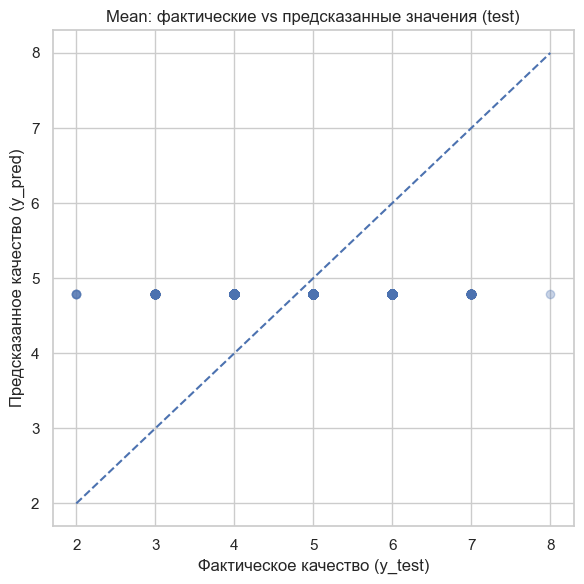

In [128]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Фактическое качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title(f"Mean: фактические vs предсказанные значения (test)")
plt.tight_layout()
plt.show()

In [129]:
baseline_name = "Baseline: median"

# средняя аренда только по train
y_train_median = y_train.median()
print(f"Среднее качество на train: {y_train_median:.2f}")

# предсказания: одно и то же число для всех объектов
y_train_pred = np.full_like(y_train, fill_value=y_train_median, dtype=float)
y_val_pred   = np.full_like(y_val,   fill_value=y_train_median, dtype=float)
y_test_pred  = np.full_like(y_test,  fill_value=y_train_median, dtype=float)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Среднее качество на train: 5.00
Модель: Baseline: median
=== Train ===
MSE : 0.81
RMSE: 0.90
MAE : 0.64
R2  : -0.0597

=== Val ===
MSE : 0.81
RMSE: 0.90
MAE : 0.63
R2  : -0.0597

=== Test ===
MSE : 0.83
RMSE: 0.91
MAE : 0.66
R2  : -0.0347



In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

linear_regression_name = "Linear Regression"

linear_regression_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

In [131]:
model = linear_regression_pipeline.fit(X_train, y_train)

In [132]:
baseline_name = f"Baseline: {linear_regression_name}"

# средняя аренда только по train
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Модель: Baseline: Linear Regression
=== Train ===
MSE : 0.53
RMSE: 0.73
MAE : 0.56
R2  : 0.3136

=== Val ===
MSE : 0.55
RMSE: 0.74
MAE : 0.57
R2  : 0.2789

=== Test ===
MSE : 0.56
RMSE: 0.75
MAE : 0.58
R2  : 0.3077



Видим, что в целом модель смогла уловить некоторые закономерности, но достаточно слабо

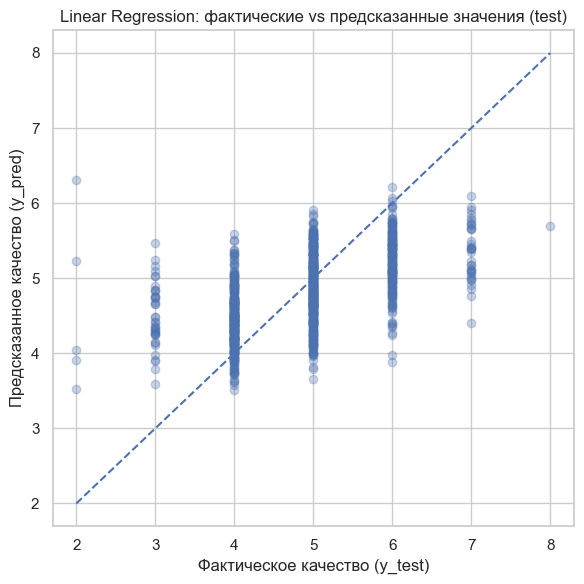

In [133]:
y_test_pred_rf = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Фактическое качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title(f"{linear_regression_name}: фактические vs предсказанные значения (test)")
plt.tight_layout()
plt.show()

Видим, что модель научилась так, что неплохо предстказывает с 4 до 6, но все, что вне этого диапазона она тоже интерпретирует как число где-то в этом диапазоне. Явно видно, что она переобучилась на этом диапазоне из-за того, что в обучающей выборке было мало примеров других знчений

In [134]:
import seaborn as sns
sns.set(style="whitegrid")

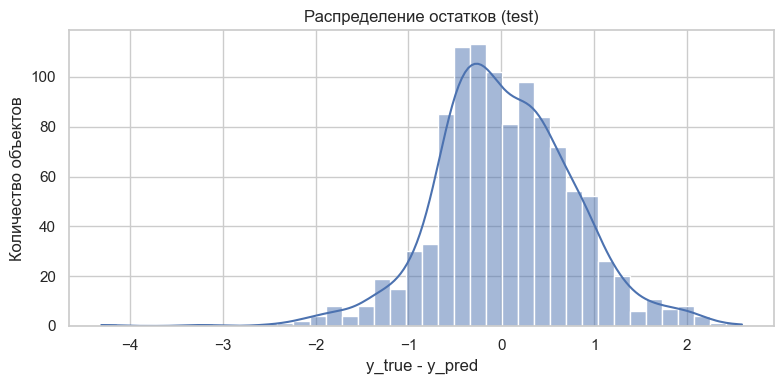

In [135]:
residuals = y_test - y_test_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Распределение остатков (test)")
plt.xlabel("y_true - y_pred")
plt.ylabel("Количество объектов")
plt.tight_layout()
plt.show()

Видим ассиметричное распределение с перекосом меньше нуля, что значит, что модель немного завышает оценку

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [137]:
linear_regression_MAE_name = "Linear Regression (MAE)"

linear_regression_MAE_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SGDRegressor(
    loss='epsilon_insensitive',
    epsilon=0,  # для чистого MAE
    random_state=42,
    max_iter=1000,
    tol=1e-3
    ))
])


In [138]:
model = linear_regression_MAE_pipeline.fit(X_train, y_train)

In [139]:
baseline_name = f"Baseline: {linear_regression_MAE_name}"

# средняя аренда только по train
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

# логируем результаты
log_results(baseline_name, "train", y_train, y_train_pred)
log_results(baseline_name, "val",   y_val,   y_val_pred)
log_results(baseline_name, "test",  y_test,  y_test_pred)

# печатаем метрики
print("Модель:", baseline_name)
print_metrics("Train", y_train, y_train_pred)
print_metrics("Val",   y_val,   y_val_pred)
print_metrics("Test",  y_test,  y_test_pred)

Модель: Baseline: Linear Regression (MAE)
=== Train ===
MSE : 0.53
RMSE: 0.73
MAE : 0.56
R2  : 0.3085

=== Val ===
MSE : 0.55
RMSE: 0.74
MAE : 0.57
R2  : 0.2769

=== Test ===
MSE : 0.56
RMSE: 0.75
MAE : 0.58
R2  : 0.3012



Видим, что при замене лосса на МАЕ качество немного упало

[4.71742582 3.93076517 5.03817711 4.75120181 4.95554739]


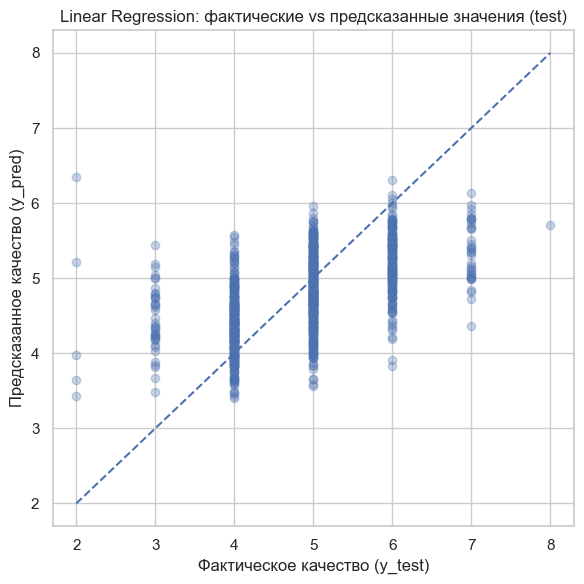

In [140]:
y_test_pred_rf = model.predict(X_test)
print(y_test_pred_rf[:5])
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Фактическое качество (y_test)")
plt.ylabel("Предсказанное качество (y_pred)")
plt.title(f"{linear_regression_name}: фактические vs предсказанные значения (test)")
plt.tight_layout()
plt.show()

На этом графике тенденция сохранилась как и раньше 

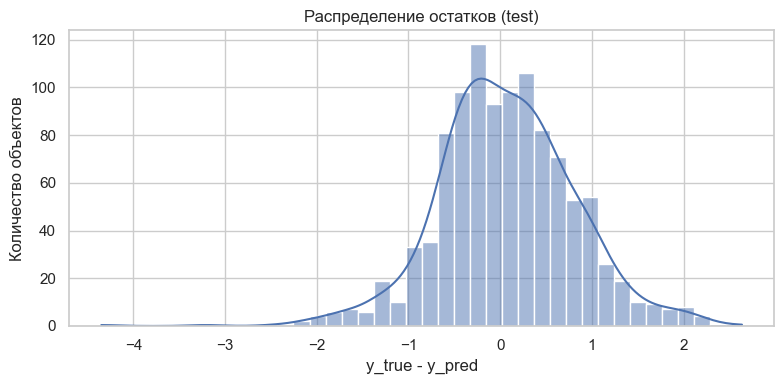

In [141]:
residuals = y_test - y_test_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Распределение остатков (test)")
plt.xlabel("y_true - y_pred")
plt.ylabel("Количество объектов")
plt.tight_layout()
plt.show()

Тут видим, что модель стала более равномерна в области 0 и график получился более симметричным и гладким. Центр распределения сместился к 0. Это положительный фактор, модель стала работать чище


In [142]:
from copy import copy

represent = []

for i in results: 

    for j in results[i]['test']:

        row = copy(results[i]['test'])

        row['baseline'] = i

        represent.append(row)

pd.DataFrame(represent).groupby('baseline').mean()

,mse,rmse,mae,r2
baseline,,,,
Baseline: Linear Regression,0.558447,0.747293,0.576290,0.307652
Baseline: Linear Regression (MAE),0.563664,0.750776,0.577489,0.301184
Baseline: mean,0.808762,0.899312,0.716438,-0.002681
Baseline: median,0.834586,0.913557,0.659774,-0.034698


# Вывод

Была обучена модель Линейной регрессии с лоссами MAE и MSE. 

Кажется, что MAE подходит в данному случае лучше, потому что по метрикам результат изменился не сильно, но качество работы модели и распределение ошибок более гладкое и симметричное относително 0, что говорит о том, что она почти не занижает и не завышает оценку